In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path|
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [38]:
class setup:
    R = 3.45 # Ом, добавочное сопротивление (указано на установке)
    C_low = 33.2
    C_high = 67.4
    
def t_coeff(n):
    '''
    Returns t-test coefficient
    n -- number of points
    '''
    assert n > 0, 'n must be positive'
    __students = [12.7062, 4.3027, 3.1824, 2.7764, 2.5706, 2.4469, 2.3646, 2.3060, 2.2622]
    if n < len(__students):
        return __students[n-1]
    else:
        return 2

In [39]:
data = mipt.read_excel('data/322.xlsx', usecols=range(12), header=(0,1)).dropna()
data

I                          II                       III                 \
      C       f0    Uc      E     C       f0    Uc    E     C       f0    Uc   
0  25.0  32000.0  5.03  0.202  25.0  32100.0  2.57  0.1  25.0  31900.0  7.40   
1  33.2  27700.0  4.27  0.202  33.2  28000.0  2.17  0.1  33.2  27700.0  6.39   
2  47.5  23200.0  3.89  0.202  47.5  23200.0  1.95  0.1  47.5  23200.0  5.78   
3  57.2  21100.0  3.61  0.202  57.2  21300.0  1.83  0.1  57.2  21100.0  5.37   
4  67.4  19400.0  3.27  0.202  67.4  19600.0  1.70  0.1  67.4  19400.0  4.96   
5  82.1  17600.0  3.08  0.202  82.1  17800.0  1.57  0.1  82.1  17600.0  4.60   
6  99.6  16100.0  2.83  0.202  99.6  16100.0  1.43  0.1  99.6  16000.0  4.21   

        
     E  
0  0.3  
1  0.3  
2  0.3  
3  0.3  
4  0.3  
5  0.3  
6  0.3

## Запускать все ячейки последовательно и равномерно...

# Таблица результатов

In [40]:
def process(data, id_str):
    U = data['Uc'].to_numpy().flatten()
    E = data['E'].to_numpy().flatten()
    C = data['C'].to_numpy().flatten() # нФ
    f = data['f0'].to_numpy().flatten() # Гц

    serror = 0.05 / C[0] # -- Погрешность емкости будет влиять 
                        # на полную погрешность индуктивности, берем макс, для оценки

    #
    # Все значение посчитаны при резонансе...
    #
    L = 1/((2 * math.pi * f)**2 * C * 1e-9) * 1e6 # мкГн -- индуктивность
    rho = 2 * math.pi * f * L * 1e-6 # Ом -- волновое сопротивление контура 
    Q = U / E # -- добротность контура
    Rsum = rho / Q # Ом -- суммарное сопротивление Rsum = Rs + RL + R (R -- на установке)
    Rs = rho * 1e-3 # Ом -- эквивалентное последовательное сопротивление (ЭПС) конденсатора 
    RL = Rsum - Rs - setup.R # Ом -- сопротивление катушки
    I = E / Rsum # А -- ток через установку (тут другого тока нет)

    results_list = {
        'C' : C,
        'f' : f,
        'U' : U,
        'E' : E,
        'L' : L,
        'Q' : Q,
        'rho' : rho,
        'Rsum' : Rsum,
        'RL' : RL,
        'I' : I
    }

    results_fmt = {
        'C': [r'$C$, нФ', '{:.1f}'],
        'f' :  [r'$f_0$, Гц', '{:.0f}'],
        'U' :  [r'$U_C$, В', '{:.2f}'],
        'E' :  [r'$\mathscr{E}$, В', '{:.1f}'],
        'L' :  [r'$L$, мкГн', '{:.1f}'],
        'Q' :  [r'$\mathcal{Q}$', '{:.1f}'],
        'rho' :  [r'$\rho$, Ом', '{:.1f}'],
        'Rsum' :  [r'$R_{\Sigma}, Ом$', '{:.1f}'],
        'RL' :  [r'$R_L$, Ом', '{:.1f}'],
        'I' :  [r'$I$, А', '{:.3f}'],
    }

    L_error = t_coeff(L.size) * L.std() / (L.size)**0.5
    RL_error = t_coeff(RL.size) * RL.std() / (RL.size)**0.5
    mean_list = {
        'names' : ['$L$, мкГн', '$R_L$, Ом'],
        'mean' : [L.mean(), RL.mean()],
        'std' : [L.std(), RL.std()],
        'error' : [L_error, RL_error],
        'serror' : [(L_error**2 + (L.mean()*serror)**2)**0.5, (RL_error**2 + (RL.mean()*serror)**2)**0.5],
    }

    RL_full_error = (RL_error**2 + (RL.mean()*serror)**2)**0.5

    mean_fmt = {
        'names' :  [r''],
        'mean' :  [r'Среднее значение', '{:.1f}'],
        'std' :  [r'Среднеквадратичное', '{:.1f}'],
        'error' :  [r'Случайная погрешность', '{:.1f}'],
        'serror' :  [r'Погрешность', '{:.1f}'],
    }

    results = pd.DataFrame(results_list)
    tab = mipt.table(results, results_fmt)
    tab.to_latex('gen/setup-{}.tex'.format(id_str))
    tab.rename().data

    mean = pd.DataFrame(mean_list)
    mean_tab = mipt.table(mean, mean_fmt)
    mean_tab.to_latex('gen/setup-mean-{}.tex'.format(id_str))
    mean_tab.rename().data
    tab.rename().data

In [41]:
process(data['I'], '1')
process(data['II'], '2')
process(data['III'], '3')

# Амплитудно-частотные характеристики

Я считал для двух значений. Меньшее -- low, большее -- high

In [42]:
data = mipt.read_excel('data/322.xlsx', usecols=range(15,24), header=(0,1)).dropna()
data


low                                 high                   
          f    Uc     x    x0     dF/pi        f     Uc     x    x0
0   25400.0  1.11   1.0  20.0  0.050000  17170.0  0.810   1.5  29.0
1   25960.0  1.37   1.5  19.0  0.078947  17830.0  1.070   2.0  28.0
2   26500.0  1.87   2.0  19.0  0.105263  18270.0  1.360   3.0  27.5
3   26770.0  2.18   3.0  19.0  0.157895  18350.0  1.430   3.0  27.5
4   26900.0  2.40   3.0  18.5  0.162162  18400.0  1.520   3.5  27.0
5   26960.0  2.53   3.0  18.5  0.162162  18500.0  1.580   4.0  27.0
6   27130.0  2.91   4.0  18.0  0.222222  18600.0  1.725   4.0  27.0
7   27200.0  3.10   4.0  18.5  0.216216  18750.0  1.940   5.0  27.0
8   27400.0  3.78   6.0  18.0  0.333333  18820.0  2.080   5.0  27.0
9   27500.0  3.90   6.0  18.0  0.333333  18860.0  2.130   5.5  26.5
10  27700.0  4.32   7.5  18.0  0.416667  19040.0  2.550   7.0  26.5
11  27800.0  4.35   8.5  18.0  0.472222  19150.0  2.790   7.5  26.0
12  27890.0  4.29   9.5  18.0  0.527778  19450.0  3.310  11.5  26.0
13  27960.0  4.20  10.0  18.0  0.555556  19820.0  2.990  16.0  25.0
14  28120.0  3.89  11.0  18.0  0.611111  20000.0  2.600  17.5  25.0
15  28280.0  3.52  12.0  18.0  0.666667  20240.0  2.180  19.0  25.0
16  28350.0  3.37  12.5  17.5  0.714286  20450.0  1.860  19.5  24.5
17  28570.0  2.87  13.0  17.5  0.742857  20580.0  1.680  20.0  24.0
18  28750.0  2.53  13.5  17.5  0.771429  20880.0  1.380  20.0  24.0
19  29000.0  2.16  14.0  17.0  0.823529  21400.0  1.020  20.0  23.0
20  29500.0  1.64  14.5  17.0  0.852941  22000.0  0.760  20.0  22.5
21  30000.0  1.26  15.0  16.5  0.909091  22500.0  0.640  20.0  22.0
22  30500.0  1.01  15.0  16.0  0.937500  22940.0  0.550  20.0  21.5

C = 33.2 нФ резонанс = 27766.0 Гц
C = 67.4 нФ резонанс = 19521.3 Гц


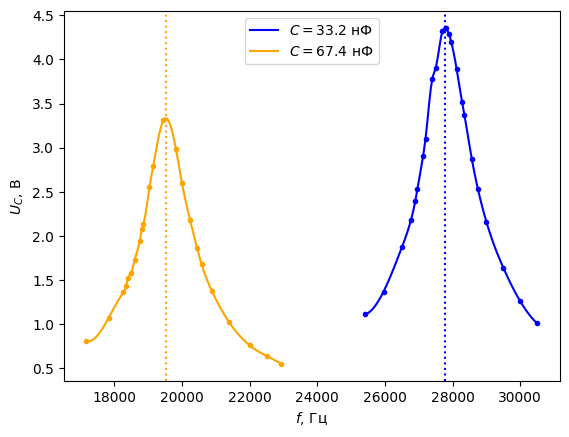

In [43]:

fmt = {
    'low' : [r'$C={0}$ нФ'.format(setup.C_low), '{:.1f}'],
    'high' : [r'$C={0}$ нФ'.format(setup.C_high), '{:.1f}'],
    ('high', 'f') :  [r'$f_0$, Гц', '{:.0f}'],
    ('high', 'Uc') :  [r'$U_C$, В', '{:.2f}'],
    ('high', 'x') :  [r'$x$, дел.', '{:.1f}'],
    ('high', 'x0') :  [r'$x_0$, дел.', '{:.1f}'],
    ('high', 'dF/pi') :  [r'$\frac{\varphi}{\pi}$, дел.', '{:.2f}'],
    ('low', 'f') :  [r'$f_0$, Гц', '{:.0f}'],
    ('low', 'Uc') :  [r'$U_C$, В', '{:.2f}'],
    ('low', 'x') :  [r'$x$, дел.', '{:.1f}'],
    ('low', 'x0') :  [r'$x_0$, дел.', '{:.1f}'],
    ('low', 'dF/pi') :  [r'$\frac{\varphi}{\pi}$, дел.', '{:.2f}'],
}

tab = mipt.table(data, fmt)
tab.to_latex('gen/measure.tex')

tab.rename().data

low = data['low']
high = data['high']

from scipy.interpolate import interp1d
def interp(x, y):
    return interp1d(x, y, kind='cubic')
    
x, y, equ_low = mipt.plot(low['f'], low['Uc'], func=interp, color='blue', label=r'$C={0}$ нФ'.format(setup.C_low))
x, y, equ_high = mipt.plot(high['f'], high['Uc'], func=interp, color='orange', label=r'$C={0}$ нФ'.format(setup.C_high))

low_resonance = op.fmin(lambda x: -equ_low(x), low['f'][0], disp=0)[0]
high_resonance = op.fmin(lambda x: -equ_high(x), high['f'][0], disp=0)[0]

plt.axvline(x=low_resonance, c='blue', ls=':')
plt.axvline(x=high_resonance, c='orange', ls=':')

plt.ylabel(r"$U_C$, В")
plt.xlabel(r"$f$, Гц")
plt.legend()
plt.savefig('gen/fig-resonance.pdf')

print('C = {:4} нФ резонанс = {:.1f} Гц'.format(setup.C_low, low_resonance))
print('C = {:4} нФ резонанс = {:.1f} Гц'.format(setup.C_high, high_resonance))

# Амплитудно-частотные характеристики в безразмерных координатах

C = 33.2 нФ 
ширина = 1.0284 - 0.9814 = 0.0470
Q = 21.26120563036633 +- 0.4252241126073266
C = 67.4 нФ 
ширина = 1.0393 - 0.9766 = 0.0627
Q = 15.960931886315699 +- 0.319218637726314


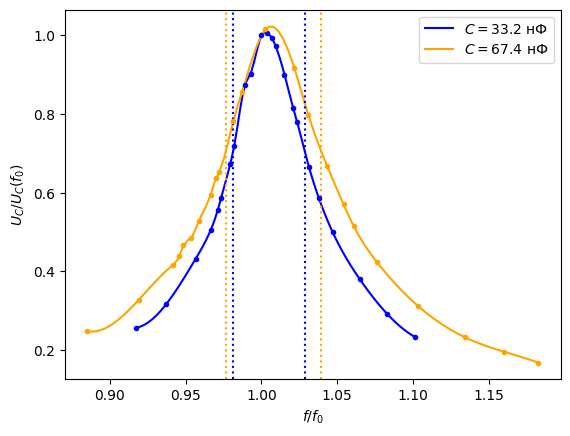

In [44]:
# Warning! Нужно запустить предыдущую ячейку чтоб тут была функции интерполяции equ_low и equ_high

data = mipt.read_excel('data/322.xlsx', usecols=range(15, 25), header=(0, 1)).dropna()
settings = mipt.read_excel('data/322.xlsx', usecols=range(0,4), header=(0, 1)).dropna()
settings = settings['I']

low = data['low']
high = data['high']

# Вычленим резонансные частоты
f0_low  = settings['f0'].tolist()[settings.index[settings['C'] == setup.C_low ].tolist()[0]]
f0_high = settings['f0'].tolist()[settings.index[settings['C'] == setup.C_high].tolist()[0]]

x_low = low['f']/f0_low
x_high = high['f']/f0_high

y_low = equ_low(low['f']) / equ_low(f0_low)
y_high = equ_high(high['f']) / equ_high(f0_high)

x, y, norm_low = mipt.plot(x_low, y_low, func=interp, color='blue', label=r'$C={0}$ нФ'.format(setup.C_low))
x, y, norm_high = mipt.plot(x_high, y_high, func=interp, color='orange',label=r'$C={0}$ нФ'.format(setup.C_high))

low_right = op.fsolve(lambda x: norm_low(x) - 0.707, 1.01)[0]
low_left = op.fsolve(lambda x: norm_low(x) - 0.707, 0.99)[0]

high_right = op.fsolve(lambda x: norm_high(x) - 0.707, 1.01)[0]
high_left = op.fsolve(lambda x: norm_high(x) - 0.707, 0.99)[0]

plt.axvline(x=low_right, c='blue', ls=':')
plt.axvline(x=low_left, c='blue', ls=':')

plt.axvline(x=high_right, c='orange', ls=':')
plt.axvline(x=high_left, c='orange', ls=':')

plt.ylabel(r"$U_C/U_C(f_0)$")
plt.xlabel(r"$f/f_0$")
plt.legend()
plt.savefig('gen/fig-resonance-norm.pdf')


Q_low = 1 / (low_right - low_left)
Q_high = 1 / (high_right - high_left)

print('C = {:4} нФ \nширина = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_low, low_right, low_left, low_right - low_left))
print('Q = {} +- {}'.format(Q_low, 2e-2 * Q_low))

print('C = {:4} нФ \nширина = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_high, high_right, high_left, high_right - high_left))
print('Q = {} +- {}'.format(Q_high, 2e-2 * Q_high))

# Фазово-частотные характеристики 

In [45]:
# Warning! Нужно запустить предыдущую ячейку

C = 33.2 нФ 
ширина = 1.0331 - 0.9812 = 0.0519
Q = 19.262657879682845 +- 0.5369418103618898
C = 67.4 нФ 
ширина = 1.0452 - 0.9763 = 0.0688
Q = 14.530422263634499 +- 0.2820319050753751


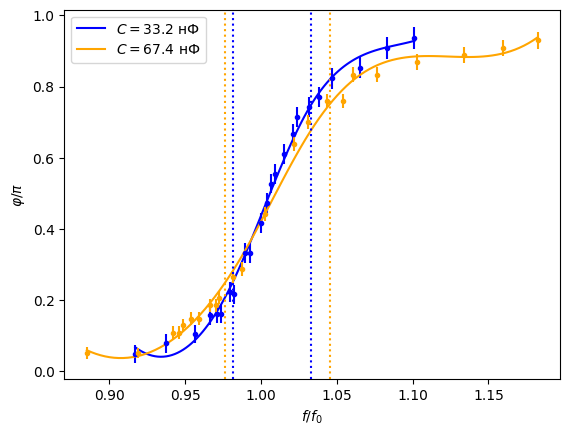

In [46]:
phi_low  = low['dF/pi']
phi_high = high['dF/pi']

from scipy.interpolate import UnivariateSpline
def interp(x, y):
    return UnivariateSpline(x, y, s=0.01)

x, y, fphi_low = mipt.plot(x_low, phi_low, yerr = phi_low * 0.5 / low['x'], func=interp, color='blue', label=r'$C={0}$ нФ'.format(setup.C_low))
x, y, fphi_high = mipt.plot(x_high, phi_high, yerr = phi_high * 0.5 / high['x'], func=interp, color='orange',label=r'$C={0}$ нФ'.format(setup.C_high))

low_right = op.fsolve(lambda x: fphi_low(x) - 3/4, 1)[0]
low_left = op.fsolve(lambda x: fphi_low(x) - 1/4, 1)[0]

high_right = op.fsolve(lambda x: fphi_high(x) - 3/4, 1)[0]
high_left = op.fsolve(lambda x: fphi_high(x) - 1/4, 1)[0]

plt.axvline(x=low_right, c='blue', ls=':')
plt.axvline(x=low_left, c='blue', ls=':')

plt.axvline(x=high_right, c='orange', ls=':')
plt.axvline(x=high_left, c='orange', ls=':')

Q_low = 1 / (low_right - low_left)
Q_high = 1 / (high_right - high_left)

plt.ylabel(r"$\varphi/\pi$")
plt.xlabel(r"$f/f_0$")
plt.legend()
plt.savefig('gen/fig-phase.pdf')

print('C = {:4} нФ \nширина = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_low, low_right, low_left, low_right - low_left))
print('Q = {} +- {}'.format(Q_low, (phi_low * 0.5 / low['x']).mean() * Q_low))

print('C = {:4} нФ \nширина = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_high, high_right, high_left, high_right - high_left))
print('Q = {} +- {}'.format(Q_high, (phi_high * 0.5 / high['x']).mean() * Q_high))

# Постройте зависимость 𝑅𝐿(𝜈0𝑛) в системе координат с началом в точке (0,6𝜈07; 0);

Text(0.5, 0, '$f$, Гц')

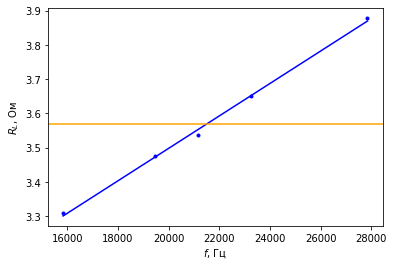

In [90]:
# Я на эту фигню подзабил, но при желании -- сохраняй

mipt.plot(f, RL, color='blue')
plt.axhline(y=RL.mean(), color='orange')

plt.ylabel(r"$R_L$, Ом")
plt.xlabel(r"$f$, Гц")
# plt.savefig('gen/fig-rl.pdf') <-- Delete comment here